In this notebook, I attempt to summarize the link performance for a selection of 30 sites. Properties displayed include latency, closeness metric, and number of files queued.

In [130]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

Below is the list of sites, truncated to 30.

In [132]:
sites = ['CERN-PROD','Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE',
            'T2-TH-CUNSTDA','EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2',
            'ITEP', 'SFU-LCG2','TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2',
            'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE',
            'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt',
            'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI',
            'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1',
            'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI',
            'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 
            'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN',
            'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH',
            'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC',
            'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW',
            'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF',
            'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP',
            'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP',
            'UKI-SOUTHGRID-SUSX', 'INFN-FRASCATI', 'UKI-SOUTHGRID-BHAM-HEP',
            'IN2P3-CPPM', 'UKI-LT2-QMUL', 'praguelcg2', 'UKI-SOUTHGRID-RALPP',
            'GoeGrid', 'UKI-LT2-UCL-HEP', 'GRIF', 'wuppertalprod', 'IN2P3-LAPP',
            'IN2P3-LPSC', 'INFN-MILANO-ATLASC', 'IN2P3-CC']
sites = sites[0:10]

In [133]:
#Query template

queryTemplate = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "6h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "mbps-dashb-1w"
          }
        },
        "2": {
          "avg": {
            "field": "closeness"
          }
        },
        "3": {
          "avg": {
            "field": "queued-total"
          }
        }
      }
    }
  }
}'''

The latency data is acquired for each of the 30 sites, over the past week, with 6-hour bins. This results in a total of 900 latency datasets (30 X 30).

In [134]:
import ast
import time

tic = time.time()

currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
#milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
#milliHour = 60*60*1000


start = currentMilliTime - milliWeek
end = currentMilliTime

totalCloseness = []
totalThroughput = []
totalQueued = []
for i in range(len(sites)):
    for j in range(len(sites)):
        dashThroughput = []
        closeness = []
        queuedTotal = []
        
        query = ast.literal_eval(queryTemplate%(sites[i],sites[j],start,end,start,end))    
        response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600) 

        for r in response['aggregations']['2']['buckets']:
            dashThroughput.append(r['1']['value'])
            closeness.append(r['2']['value'])
            queuedTotal.append(r['3']['value'])


        totalThroughput.append(np.array(dashThroughput,dtype=np.float))
        totalCloseness.append(np.array(closeness,dtype = np.float))
        totalQueued.append(np.array(queuedTotal,dtype = np.float))
        
toc = time.time()

print('This aggregation over %i X %i links took %f seconds'%(len(sites),len(sites),toc-tic))

This aggregation over 10 X 10 links took 191.342215 seconds


In [135]:
index = 0
dim = len(sites)
t = np.zeros((dim,dim))
c = np.zeros((dim,dim))
f = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        t[i,j] = np.nanmean(np.array(totalThroughput[index],dtype=float))
        c[i,j] = np.nanmean(np.array(totalCloseness[index],dtype=float))
        f[i,j] = np.nanmean(np.array(totalQueued[index],dtype=float))
        index +=1


/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  war

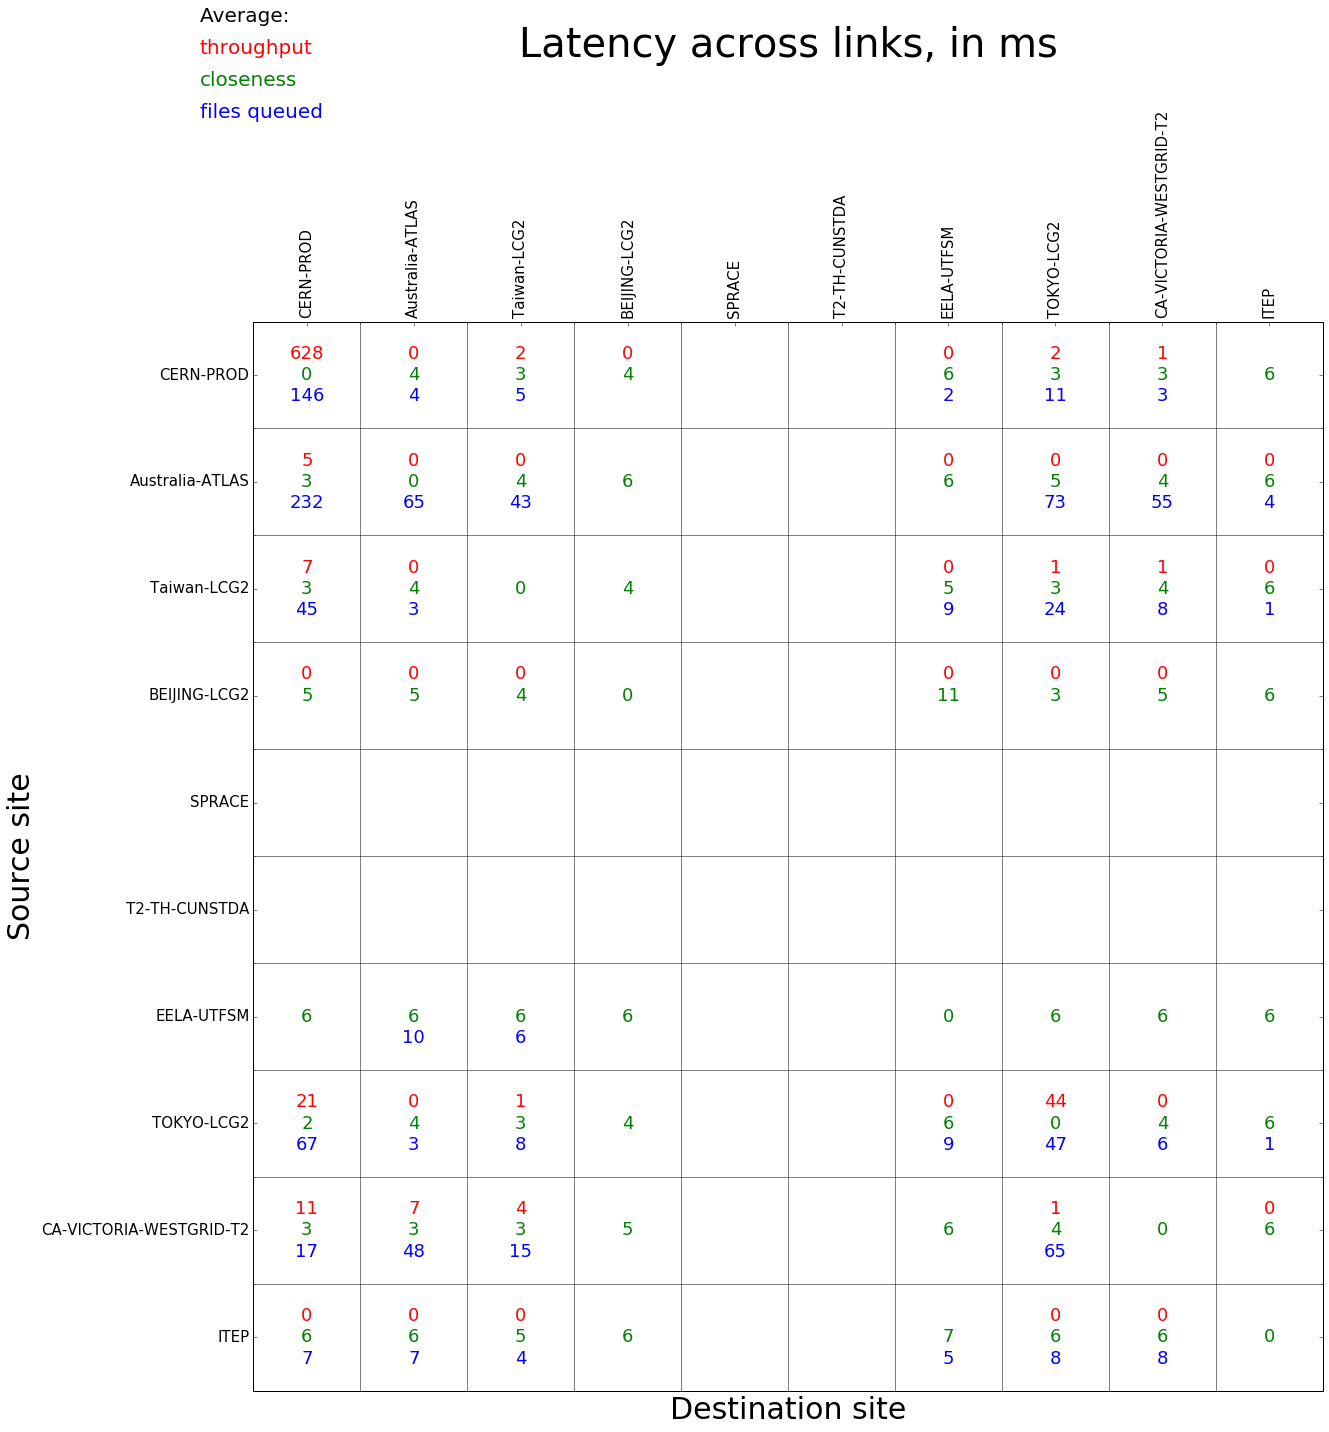

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator

#Display colors corresponding to latency stability
cMap = ListedColormap(['white'])
plt.figure(figsize=(20,20))
#Force colormap to range between 0 and 1
plt.imshow(np.zeros((dim,dim)),cmap=cMap,interpolation='none')


#Set numeric labels
for i in range(len(sites)):
    for j in range(len(sites)):
        if np.logical_not(np.isnan(t[i,j])):
            plt.text(i,j-0.2,"%.0f"%(t[i,j]),color='r',size=18,ha='center',va='center')
        if np.logical_not(np.isnan(c[i,j])):
            plt.text(i,j,    "%.0f"%(c[i,j]),color='g',size=18,ha='center',va='center')
        if np.logical_not(np.isnan(f[i,j])):
            plt.text(i,j+0.2,"%.0f"%(f[i,j]),color='b',size=18,ha='center',va='center')


plt.text(-1,-3.3,"Average:",color='k',size=20)
plt.text(-1,-3,"throughput",color='r',size=20)
plt.text(-1,-2.7,"closeness",color='g',size=20)
plt.text(-1,-2.4,"files queued",color='b',size=20)
ax = plt.gca() 

#Draw the boxes for the squares
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',linestyle='-')

#Set major axis ticks and labels correctly
ax.yaxis.set_ticklabels(sites)
ax.xaxis.set_ticklabels(sites)
ax.xaxis.tick_top()

plt.yticks(range(dim),rotation=0)
plt.xticks(range(dim),rotation=90)

#Set titles
plt.ylabel('Source site',size=30)
plt.xlabel('Destination site',size=30)
plt.title('Latency across links, in ms\n',size=40,y=1.2)
plt.tight_layout()
plt.show()